In [1]:
%pip install pytrends

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message='.*Downcasting object dtype arrays on .fillna, .ffill, .bfill.*')

from pytrends.request import TrendReq
import matplotlib.pyplot as plt

from utils import (
    COIN_DETAILS_FILE_PATH,
    GOOGLE_TRENDS_DATA_FILE_PATH,
    SAMPLE_SYMBOLS,
    parse_date)

In [3]:
pytrends = TrendReq(hl='en-US', tz=360)

coin_info_data = pd.read_csv(COIN_DETAILS_FILE_PATH)
coin_info_data["keywords"] = coin_info_data["keywords"].astype(str)

# Create a mapping of symbols to their specific keywords
symbol_keyword_mapping = dict(zip(coin_info_data['symbol'], coin_info_data['keywords']))

def get_google_trends_data(keyword, retries=5, delay=5):
    attempt = 0
    while attempt < retries:
        try:
            pytrends.build_payload([keyword])
            trends_data = pytrends.interest_over_time()
            trends_data = trends_data.reset_index().infer_objects(copy=False)
            
            if not trends_data.empty:
                # Convert date to string format without time component
                trends_data['date'] = pd.to_datetime(trends_data['date']).dt.date
            
            return trends_data
        except Exception as e:
            if '429' in str(e):
                print(f"Received 429 error for {keyword}. Retrying after {delay} seconds...")
                time.sleep(delay)
                attempt += 1
                delay *= 2  # Exponential backoff
            else:
                print(f"Request failed for keywords {keyword}: {e}")
                break
    return pd.DataFrame()  # Return empty DataFrame on failure

already_downloaded = set()

# Initialize an empty DataFrame to store trends data
if os.path.exists(GOOGLE_TRENDS_DATA_FILE_PATH):
    all_trends_data = pd.read_csv(GOOGLE_TRENDS_DATA_FILE_PATH)
    already_downloaded = set(all_trends_data['symbol'].unique())
else:
    all_trends_data = pd.DataFrame()

# Extract unique names
unique_symbols = set(coin_info_data['symbol'].unique())

symbols_to_retrieve_set = unique_symbols - already_downloaded
print(f'Retrieving Google Trends Data for {len(symbols_to_retrieve_set)}')

keywords_to_retrieve = [symbol_keyword_mapping[symbol] for symbol in symbols_to_retrieve_set if symbol in symbol_keyword_mapping]

print (keywords_to_retrieve)
for i in range(0, len(keywords_to_retrieve)):
    keyword = keywords_to_retrieve[i]
    
    if len(keyword) > 4:
        try:
            print(f"Fetching data for: {keyword}, length: {len(keyword)}")
            trends_data = get_google_trends_data(keyword)
            if not trends_data.empty:

                # Filter and store only necessary columns that exist in the DataFrame
                existing_columns = ['date', keyword] if keyword in trends_data.columns else ['date']
                
                if len(existing_columns) > 1:  # Ensure there are columns other than 'date'
                    trends_data = trends_data[existing_columns]
                    
                    # Melt the DataFrame to have 'date', 'name', and 'value' columns
                    trends_data = trends_data.melt(id_vars=['date'], var_name='name', value_name='trend_score')
                    
                    # Add the symbol column based on the keyword
                    trends_data['symbol'] = trends_data['name'].map({v: k for k, v in symbol_keyword_mapping.items()})

                    # Reorder the columns to be date, symbol, trend_score
                    trends_data = trends_data[['date', 'symbol', 'name', 'trend_score']]

                    # Append to the main DataFrame
                    all_trends_data = pd.concat([all_trends_data, trends_data], ignore_index=True)
                    
                    # Save the updated DataFrame to CSV incrementally
                    all_trends_data.to_csv(GOOGLE_TRENDS_DATA_FILE_PATH, index=False)
            
            # Respect rate limiting
            time.sleep(5)
        
        except Exception as e:
            print(f"Failed to fetch data for {keyword}: {e}")

# Display the final DataFrame
all_trends_data.head()


Retrieving Google Trends Data for 60
['Cornucopias coin', 'Tachyon Protocol', 'Launchblock.com', 'Nsure.Network', 'Adappter Token', 'Neutrino System Base Token', 'Darwinia Commitment Token', 'Idavoll DAO', 'Göztepe S.K. Fan Token', 'MileVerse', 'Paribus coin', 'nan', 'Wrapped Alvey Chain', 'dYdX (ethDYDX)', 'Tellor Protocol', 'Unisocks coin', 'Agoras: Currency of Tau', 'ReapChain', 'Nuco.cloud', 'ParagonsDAO', 'Origin DeFi Governance', 'AhaToken', 'UBIX.Network', 'nan', 'NuriFootBall', 'Propel blockchain', 'SakeToken', 'Chimpion coin', 'Blockzero Labs', 'Etherisc DIP Token', 'nan', 'RichQUACK.com', 'Cashtree Token', 'Grin blockchain', 'Woonkly Power', 'Ellipsis coin', 'YFDAI.FINANCE', 'Cyclub coin', 'Aluna.Social', 'nan', 'Hiblocks', 'EveryCoin ', 'TomTomCoin', 'GoCrypto Token', 'WOM Protocol', 'nan', 'Samsunspor Fan Token', 'xHashtag AI', 'Bubblefong coin', 'Tarot lending', 'Aurora network', 'Aston Martin Cognizant Fan Token', 'Lovely Finance project', 'BonusCloud', 'MintMe.com Coin',

,date,symbol,name,trend_score
0,2019-08-04,BNX,BinaryX,0
1,2019-08-11,BNX,BinaryX,0
2,2019-08-18,BNX,BinaryX,0
3,2019-08-25,BNX,BinaryX,0
4,2019-09-01,BNX,BinaryX,0


# EDA

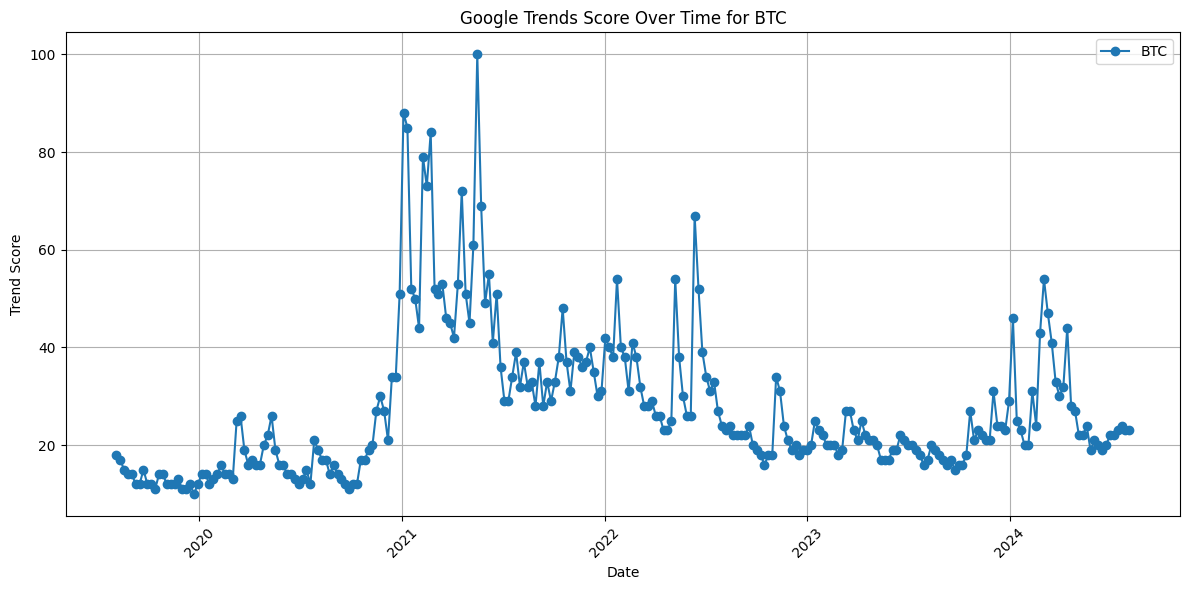

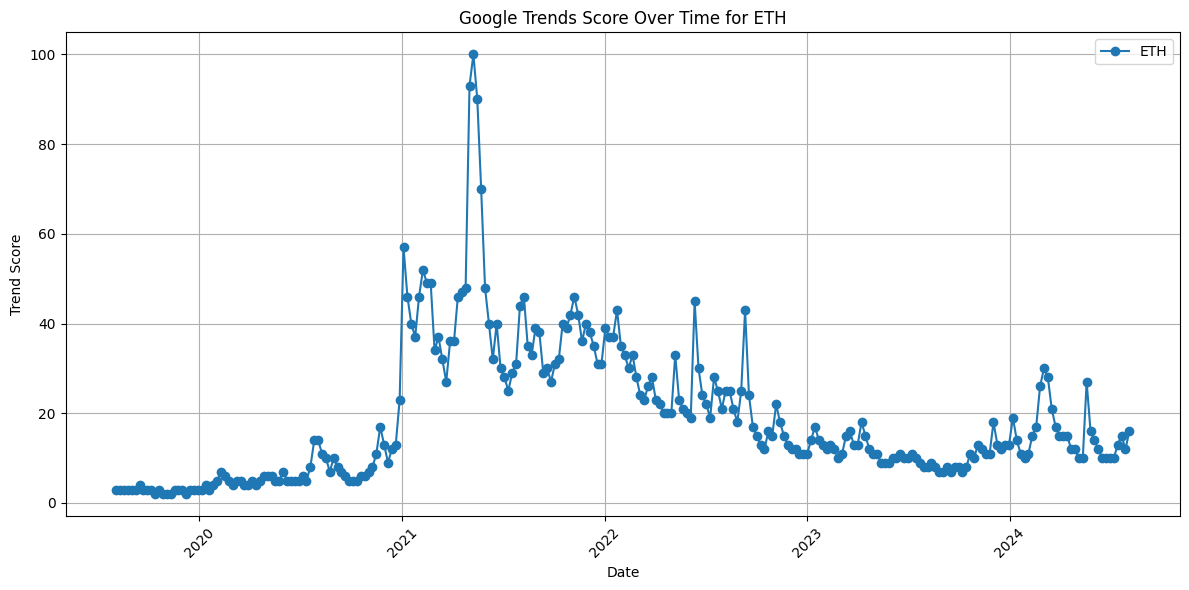

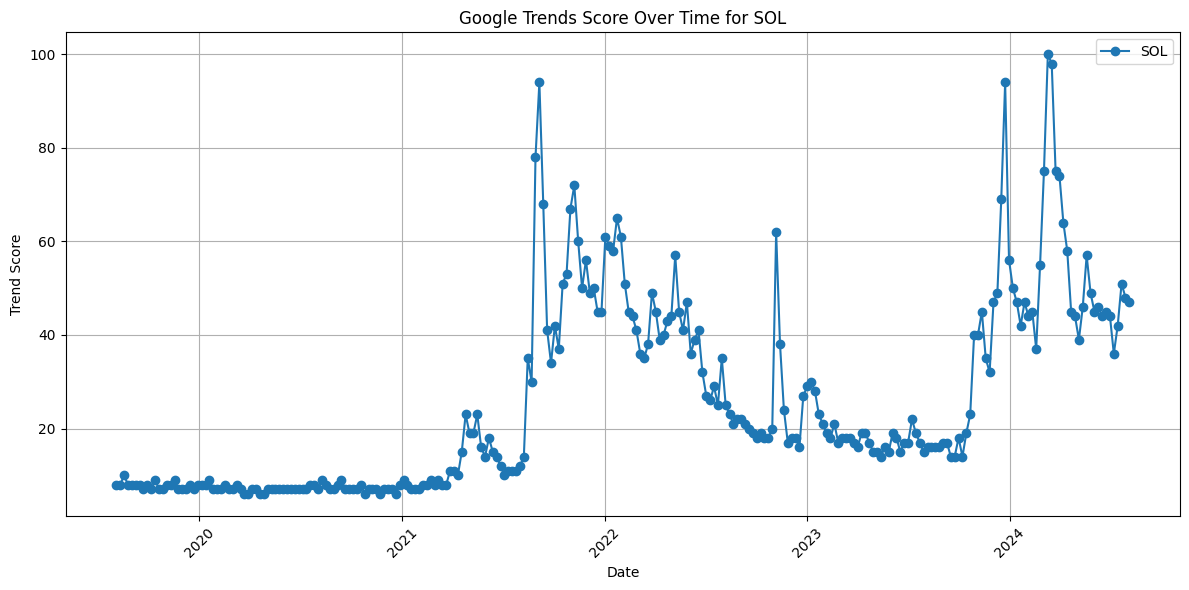

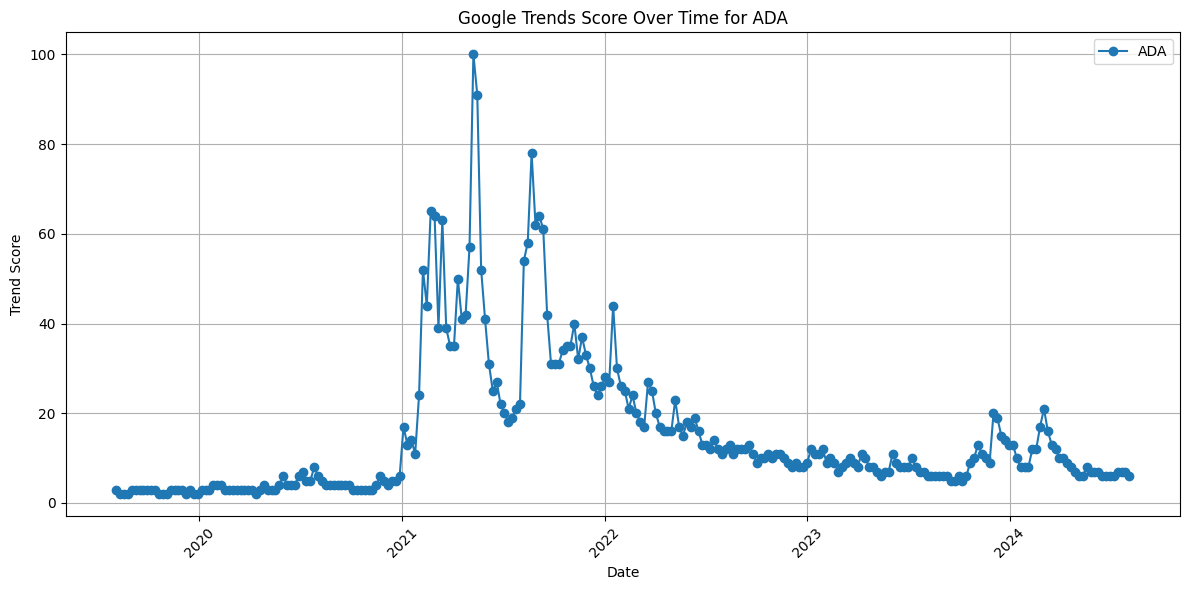

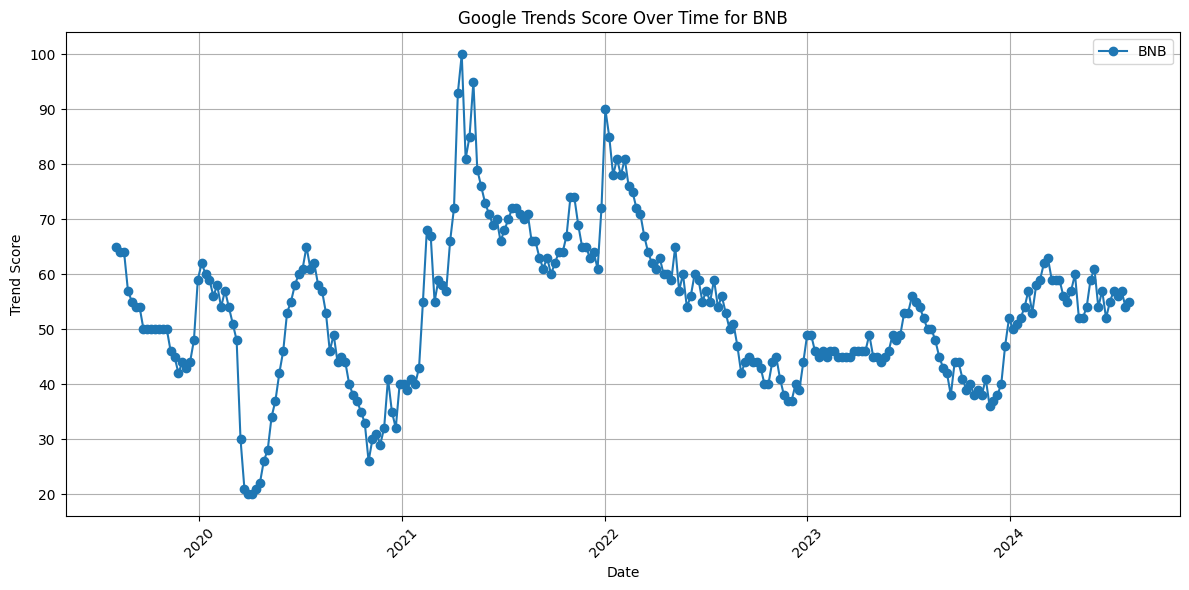

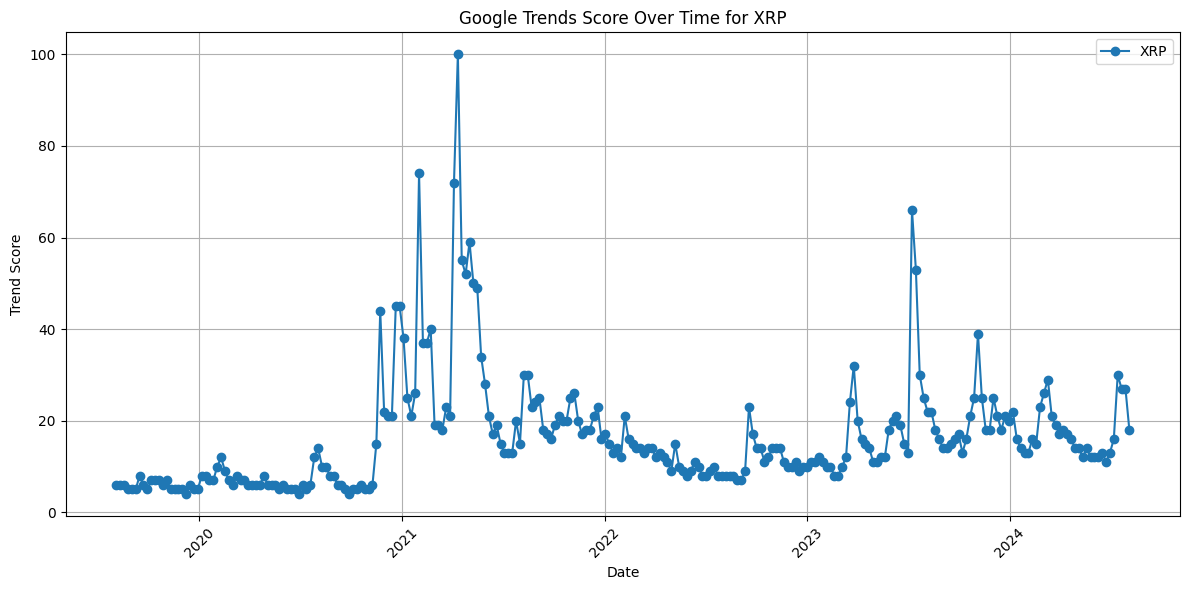

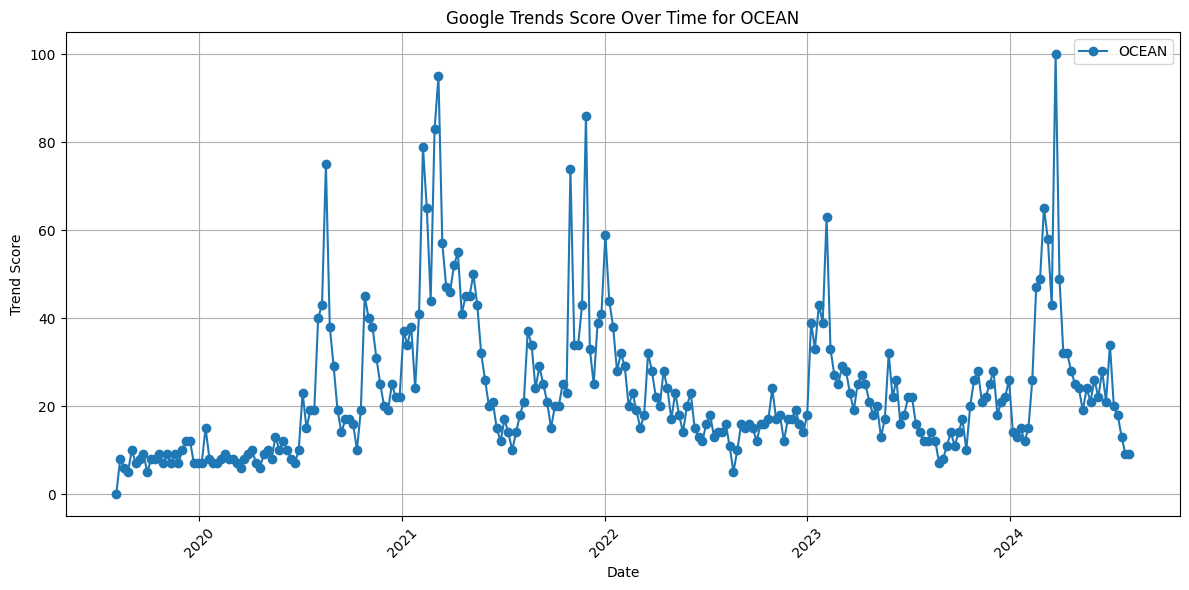

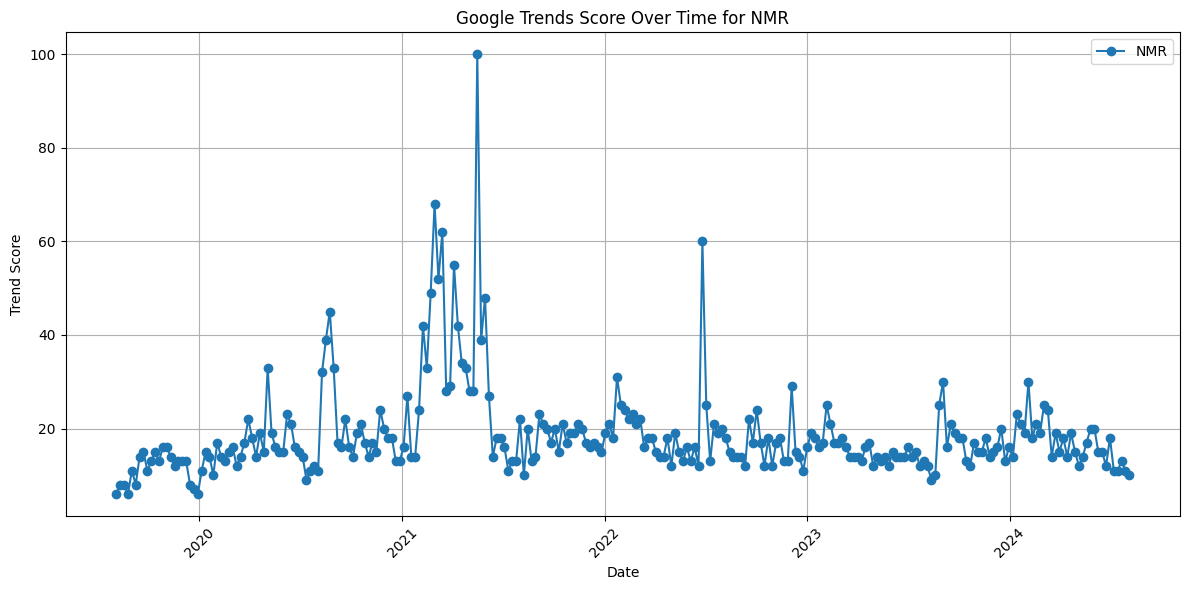

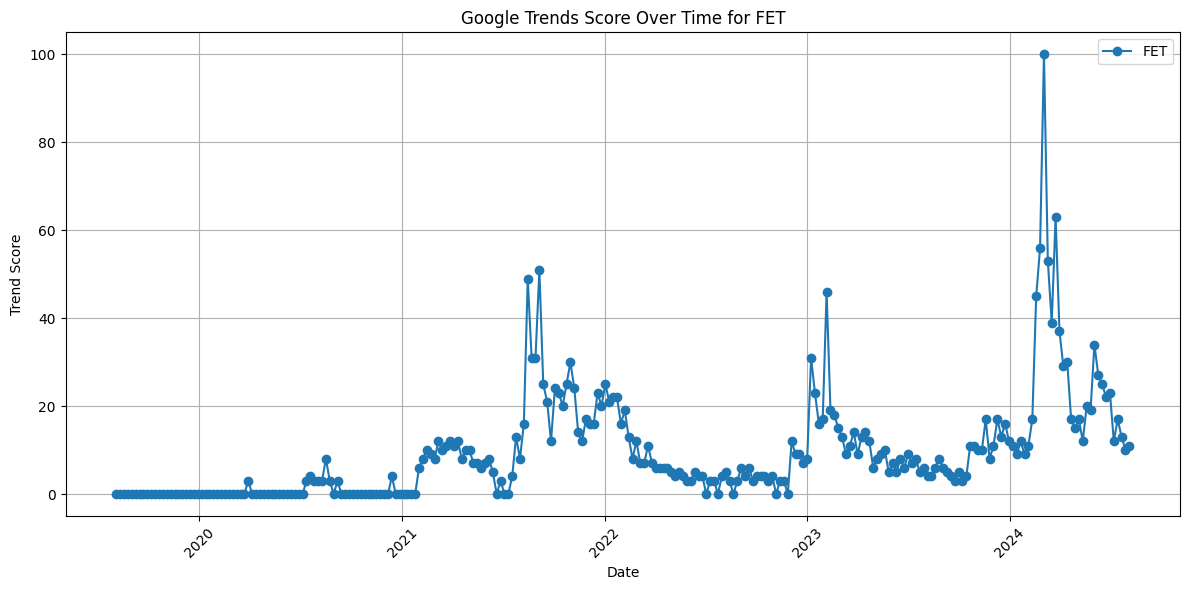

In [4]:
# Load Google Trends data
google_trends_data = pd.read_csv(GOOGLE_TRENDS_DATA_FILE_PATH)
google_trends_data['date'] = google_trends_data['date'].apply(parse_date)
google_trends_data['date'] = google_trends_data['date'].dt.date
    
def plot_google_trends(symbols):
    for symbol in symbols:
        plt.figure(figsize=(12, 6))
        symbol_data = google_trends_data[google_trends_data['symbol'] == symbol]
        plt.plot(symbol_data['date'], symbol_data['trend_score'], marker='o', linestyle='-', label=symbol)
        
        plt.title(f'Google Trends Score Over Time for {symbol}')
        plt.xlabel('Date')
        plt.ylabel('Trend Score')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Plot the Google Trends data for the sample symbols
plot_google_trends(SAMPLE_SYMBOLS)